In [33]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from time import sleep
from typing import Tuple, List, Dict
from functools import partial, reduce
from tqdm import tqdm

## The Problem
Problème du sac à dos : on dispose d'un ensemble d'objets, chacun ayant un poids et une valeur. On dispose également d'un sac à dos dont on connait la capacité maximale. Le but est de remplir le sac à dos avec des objets de telle sorte que la valeur totale des objets soit maximale tout en respectant la contrainte de poids.

In [34]:
from benchmark.read import list_benchmarks, read_kp_benchmark

list_benchmarks('kp')

['.DS_Store',
 '__MACOSX',
 'KP_p-3_n-100_ins-1.dat',
 'KP_p-3_n-100_ins-10.dat',
 'KP_p-3_n-100_ins-2.dat',
 'KP_p-3_n-100_ins-3.dat',
 'KP_p-3_n-100_ins-4.dat',
 'KP_p-3_n-100_ins-5.dat',
 'KP_p-3_n-100_ins-6.dat',
 'KP_p-3_n-100_ins-7.dat',
 'KP_p-3_n-100_ins-8.dat',
 'KP_p-3_n-100_ins-9.dat',
 'KP_p-3_n-10_ins-1.dat',
 'KP_p-3_n-10_ins-10.dat',
 'KP_p-3_n-10_ins-2.dat',
 'KP_p-3_n-10_ins-3.dat',
 'KP_p-3_n-10_ins-4.dat',
 'KP_p-3_n-10_ins-5.dat',
 'KP_p-3_n-10_ins-6.dat',
 'KP_p-3_n-10_ins-7.dat',
 'KP_p-3_n-10_ins-8.dat',
 'KP_p-3_n-10_ins-9.dat',
 'KP_p-3_n-20_ins-1.dat',
 'KP_p-3_n-20_ins-10.dat',
 'KP_p-3_n-20_ins-2.dat',
 'KP_p-3_n-20_ins-3.dat',
 'KP_p-3_n-20_ins-4.dat',
 'KP_p-3_n-20_ins-5.dat',
 'KP_p-3_n-20_ins-6.dat',
 'KP_p-3_n-20_ins-7.dat',
 'KP_p-3_n-20_ins-8.dat',
 'KP_p-3_n-20_ins-9.dat',
 'KP_p-3_n-30_ins-1.dat',
 'KP_p-3_n-30_ins-10.dat',
 'KP_p-3_n-30_ins-2.dat',
 'KP_p-3_n-30_ins-3.dat',
 'KP_p-3_n-30_ins-4.dat',
 'KP_p-3_n-30_ins-5.dat',
 'KP_p-3_n-30_ins-6.dat

In [35]:
kp_params_dict = read_kp_benchmark(p=3, n=10, instance=5)

N_OBJECTIVE_FUNCTIONS: int = kp_params_dict["n_objective_functions"]
N_OBJECTS: int = kp_params_dict["n_objects"]
MAX_WEIGHT_CONSTRAINT: int = kp_params_dict["max_weight_constraint"]
PROFITS_MATRIX: np.ndarray = kp_params_dict["profits_matrix"]
OBJECTS_WEIGHTS: np.ndarray = kp_params_dict["objects_weights"]

Number of objective functions (p) : 3
Number of objects (n) : 10
Capacity of the knapsack (W) : 2263
Profits of the objects in each objective function : [[895 629 105 976 672 508  16 216 235 192]
 [431 548  16  39  25 922 521 648  92 522]
 [541 131  57 964 385 866 379 662 508 562]]
Weights of the objects (w) [665 402 191 769 378 862 277 394  77 512]


## Individual + Population

In [36]:
def init_individual(size: int):
    return np.random.choice([0.0, 1.0], size=(size,))


test_ind = init_individual(N_OBJECTS)
print(test_ind)

test_ind.nonzero()

[1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]


(array([0, 1, 2, 3, 4, 7, 8, 9], dtype=int64),)

In [37]:
def init_population(size: int, individual_size: int):
    return [init_individual(individual_size) for _ in range(size)]


test_pop = init_population(10, N_OBJECTS)
np.array(test_pop)

array([[1., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 1., 1., 0., 0.],
       [1., 0., 1., 0., 1., 1., 0., 0., 1., 1.],
       [1., 0., 1., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 0., 1., 0., 0.],
       [1., 1., 1., 1., 0., 1., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 1., 0., 1., 1.]])

## Fitness

In [82]:
def fitness_objectives(individual: np.ndarray, profits_matrix: np.ndarray) -> np.ndarray:
    """
    Calcule les valeurs de fitness pour chaque objectif d'un individu pour le problème du knapsack multi-objectif.

    :param individu: un tableau numpy de 0 et 1 représentant les objets sélectionnés pour le sac à dos.
    :param profits_matrix: un tableau numpy de dimensions (p, n) représentant les profits de chaque objet pour chaque objectif.
    :return: un tableau numpy de dimensions (p,) représentant les valeurs de fitness pour chaque objectif.
    """
    # Calcule la valeur de fitness pour chaque objectif
    fitness_values = np.sum(profits_matrix * individual, axis=1)  #todo : t'es sure ? demande au prof

    # change all zero to 1e-100
    fitness_values[fitness_values == 0] = 1e-100
    return fitness_values


def fitness(individual: np.ndarray, profits_matrix: np.ndarray) -> float:
    """
    Calcule la valeur de fitness d'un individu pour le problème du knapsack multi-objectif.

    :param individu: un tableau numpy de 0 et 1 représentant les objets sélectionnés pour le sac à dos.
    :param profits_matrix: un tableau numpy de dimensions (p, n) représentant les profits de chaque objet pour chaque objectif.
    :return: un float représentant la valeur de fitness.
    """
    # Calcule la valeur de fitness pour chaque objectif
    fitness_values = fitness_objectives(individual, profits_matrix)
    # Calcule la valeur de fitness totale : sum(ln(fitness_values))
    # on utilise log pour éviter les valeurs trop grandes, mettre tout sur la même échelle entre gullemnt

    return np.sum(np.log(fitness_values))

print(test_ind)
print(fitness(test_ind, PROFITS_MATRIX))
fitness_objectives(test_ind, PROFITS_MATRIX)

[0. 0. 0. 0. 1. 1. 0. 1. 0. 1.]
22.841981587944737


array([1588., 2117., 2475.])

In [102]:
# sort by fitness
def sort_population(population: List[np.ndarray], profits_matrix: np.ndarray, descending=True) -> List[np.ndarray]:
    """
    Trie une population par fitness décroissant.
    """

    return sorted(population, key=lambda individual: fitness(individual, profits_matrix), reverse=True if descending else False)

test_pop = init_population(10, N_OBJECTS)

for ind in sort_population(test_pop, PROFITS_MATRIX):
    print(ind, fitness(ind, PROFITS_MATRIX))

[1. 1. 1. 1. 0. 1. 0. 0. 1. 0.] 23.769192581883015
[1. 1. 0. 0. 0. 1. 0. 1. 0. 1.] 23.753222172697306
[1. 1. 1. 0. 1. 0. 0. 1. 0. 1.] 23.353042806927654
[0. 0. 0. 1. 0. 1. 1. 0. 1. 1.] 23.306799490699948
[1. 1. 0. 0. 1. 1. 0. 0. 0. 0.] 23.027329775109706
[0. 0. 1. 1. 1. 0. 0. 1. 0. 1.] 22.683964311975043
[0. 0. 1. 1. 0. 1. 0. 0. 0. 1.] 22.600918838344427
[1. 0. 0. 1. 1. 0. 1. 0. 0. 0.] 22.498094949078055
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0.] 22.165947659548838
[1. 1. 0. 1. 0. 0. 0. 0. 0. 0.] 22.149650725129455


## Faisability & Repare

In [39]:
def faisability(individual: np.ndarray, objects_weights: np.ndarray, capacity_constraint: int) -> Tuple[bool, int]:
    """
    Calcule la faisabilité d'un individu pour le problème du knapsack multi-objectif.
    """

    sum_knapsack_weights = np.sum(individual * objects_weights)
    if sum_knapsack_weights > capacity_constraint:
        return False, sum_knapsack_weights
    return True, sum_knapsack_weights


print(MAX_WEIGHT_CONSTRAINT)
faisability(test_ind, objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT)

2263


(False, 3388.0)

In [40]:
def repare(individual, objects_weights, capacity_constraint):
    individual = individual.copy()
    if indexes := list(individual.nonzero()[0]):
        while not faisability(individual, objects_weights, capacity_constraint)[0]:
            # choisir un élement du sac
            index = random.choice(indexes)
            # le retirer du sac
            individual[index] = 0
            # le retirer de la liste des index
            indexes.remove(index)
    #else:
    #    individual[random.randint(0, len(individual) - 1)] = 1
    return individual  # mm si ça marche sans retourner


test_ind = init_individual(N_OBJECTS)
print(test_ind, faisability(test_ind, objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT))
test_ind = repare(test_ind, objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT)
print(test_ind, faisability(test_ind, objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT))

[0. 1. 0. 0. 1. 1. 0. 1. 0. 1.] (False, 2548.0)
[0. 0. 0. 0. 1. 1. 0. 1. 0. 1.] (True, 2146.0)


## Vizualise population

### Print individual

In [41]:
def print_individual(individual: np.ndarray, profits_matrix: np.ndarray, objects_weights: np.ndarray, full_print_individual : bool = False, full_print_profits : bool = False) -> None:
    """
    Print the individual and its fitness.
    """

    if len(individual) <= 10 or full_print_individual:
        str_individual = f"{individual}, fit={fitness(individual, profits_matrix):>4.2f}"
    else:
        str_individual = f"{individual[:8]}...{individual[-2:]}, fit={fitness(individual, profits_matrix):>4.2f}"
    profits = fitness_objectives(individual, profits_matrix)
    if len(profits) <= 5 or full_print_profits:
        str_profits = f", profits={str(profits):>19}"
    else:
        str_profits = f", profits={str(profits[:3])}...{str(profits[-2:]):>19}"

    str_total_weight = f", weight={np.sum(individual * objects_weights):>5.0f}"

    print(str_individual + str_profits + str_total_weight)


print_individual(test_ind, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print_individual(np.ones(N_OBJECTS), PROFITS_MATRIX, OBJECTS_WEIGHTS)

for _ in range(10):
    print_individual(init_individual(N_OBJECTS), PROFITS_MATRIX, OBJECTS_WEIGHTS)

[0. 0. 0. 0. 1. 1. 0. 1. 0. 1.], fit=22.84, profits=[1588. 2117. 2475.], weight= 2146
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], fit=25.16, profits=[4444. 3764. 5055.], weight= 4527
[1. 1. 0. 1. 1. 0. 1. 1. 0. 0.], fit=23.86, profits=[3404. 2212. 3062.], weight= 2885
[1. 1. 1. 1. 0. 0. 0. 1. 0. 0.], fit=23.14, profits=[2821. 1682. 2355.], weight= 2421
[0. 1. 1. 1. 1. 0. 0. 0. 1. 1.], fit=22.93, profits=[2809. 1242. 2607.], weight= 2329
[1. 1. 1. 1. 0. 0. 1. 0. 0. 0.], fit=22.86, profits=[2621. 1555. 2072.], weight= 2304
[1. 1. 1. 0. 0. 1. 0. 0. 0. 0.], fit=22.60, profits=[2137. 1917. 1595.], weight= 2120
[1. 1. 0. 0. 0. 0. 0. 0. 0. 1.], fit=21.88, profits=[1716. 1501. 1234.], weight= 1579
[1. 0. 0. 1. 0. 0. 0. 1. 1. 0.], fit=22.74, profits=[2322. 1210. 2675.], weight= 1905
[1. 0. 1. 0. 1. 1. 1. 1. 1. 1.], fit=24.30, profits=[2839. 3177. 3960.], weight= 3356
[1. 1. 0. 1. 0. 1. 0. 1. 0. 1.], fit=24.40, profits=[3416. 3110. 3726.], weight= 3604
[1. 0. 1. 1. 1. 1. 0. 0. 1. 1.], fit=24.07, profits=[3

### Plot population

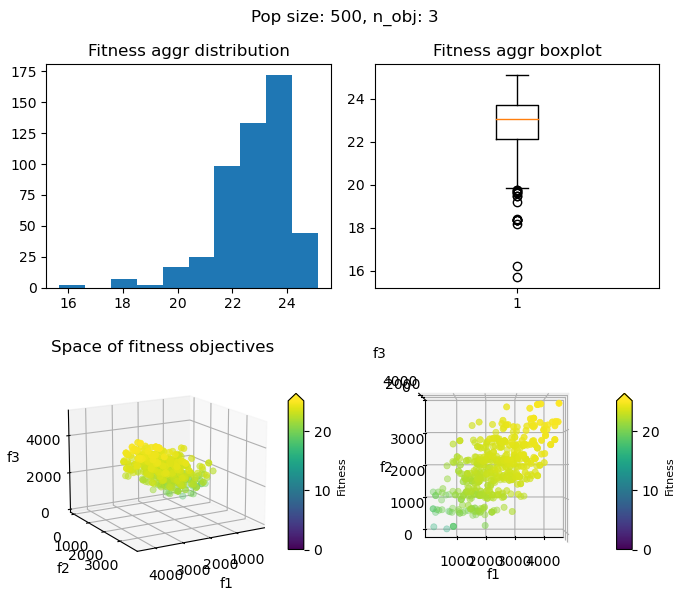

In [42]:
def visualize_population(population: List[np.ndarray], profits_matrix: np.ndarray) -> None:
    """
    Visualize a population of individuals in fitness space.
    """

    dim = profits_matrix.shape[0]
    display_second_plot = 2 <= dim <= 3

    fig = plt.figure(figsize=(7, 4 if not display_second_plot else 6))
    fig.suptitle("Pop size: " + str(len(population)) + ", n_obj: " + str(profits_matrix.shape[0]))

    # Fitness distribution
    ax = fig.add_subplot(2 if display_second_plot else 1, 2, 1)
    fitnesses_agg = [fitness(ind, profits_matrix) for ind in population]
    ax.hist(fitnesses_agg)
    ax.set_title("Fitness aggr distribution")

    # Fitness boxplot
    ax = fig.add_subplot(2 if display_second_plot else 1, 2, 2)
    ax.boxplot(fitnesses_agg)
    ax.set_title("Fitness aggr boxplot")

    # 3D Viz of fitness
    if display_second_plot:
        if dim == 3:
            fitness_objectives_values = [fitness_objectives(ind, profits_matrix) for ind in population]
            f1, f2, f3 = zip(*fitness_objectives_values)

            ax = fig.add_subplot(2, 2, 3, projection='3d')
            ax.view_init(15, 60)
            scatter = ax.scatter(f1, f2, f3, c=fitnesses_agg, cmap='viridis', linewidth=0.5)
            ax.set_title("Space of fitness objectives")
            ax.set_xlabel("f1")
            ax.set_ylabel("f2")
            ax.set_zlabel("f3")
            # add color bar (min value is 0)
            cbar = fig.colorbar(scatter, shrink=0.7, aspect=10, extend='max')
            cbar.ax.set_ylabel('Fitness', fontsize=8)
            scatter.set_clim(vmin=0)


            ax = fig.add_subplot(2, 2, 4, projection='3d')
            ax.view_init(90, 90 * 3)
            scatter = ax.scatter(f1, f2, f3, c=fitnesses_agg, cmap='viridis', linewidth=0.5)
            #ax.set_title("Space of fitness objectives")
            ax.set_xlabel("f1")
            ax.set_ylabel("f2")
            ax.set_zlabel("f3")
            # add color bar (min value is 0)
            cbar = fig.colorbar(scatter, shrink=0.7, aspect=10, extend='max')
            cbar.ax.set_ylabel('Fitness', fontsize=8)

            scatter.set_clim(vmin=0)

        elif dim == 2:
            fitness_objectives_values = [fitness_objectives(ind, profits_matrix) for ind in population]

            f1, f2 = zip(*fitness_objectives_values)

            ax = fig.add_subplot(2, 2, 3)
            scatter = ax.scatter(f1, f2, c=fitnesses_agg, cmap='viridis', linewidth=0.5)
            ax.set_title("Space of fitness objectives")
            ax.set_xlabel("f1")
            ax.set_ylabel("f2")

            ax = fig.add_subplot(2, 2, 4)
            scatter = ax.scatter(f1, f2, c=fitnesses_agg, cmap='viridis', linewidth=0.5)
            #ax.set_title("Space of fitness objectives")
            ax.set_xlabel("f1")
            ax.set_ylabel("f2")

            # add color bar
            fig.colorbar(scatter, ax=ax, shrink=0.7, aspect=10, label="Fitness aggregate (energy)")

    fig.tight_layout(h_pad=2.5)
    plt.show()


test_pop = init_population(500, N_OBJECTS)
visualize_population(test_pop, PROFITS_MATRIX)

## Compare

### Diversity

In [43]:
def count_diff(x1: np.ndarray, x2: np.ndarray) -> int:
    """
    Return the number of differences between x1 and x2.
    """
    if len(x1) != len(x2):
        raise ValueError("x1 and x2 must have the same length")
    return np.sum(x1 != x2)


def percent_diff(x1: np.ndarray, x2: np.ndarray) -> float:
    """
    Return the percentage of differences between x1 and x2.
    """
    return count_diff(x1, x2) / len(x1)


def diversity(population: List[np.ndarray]) -> float:
    """
    Return the average number of differences between individuals in the population.
    """
    n = len(population)
    return np.sum([count_diff(population[i], population[j]) for i in range(n) for j in range(i + 1, n)]) / (
                n * (n - 1) / 2)


def percent_diversity(population: List[np.ndarray]) -> float:
    """
    Return the average percentage of differences between individuals in the population.
    """
    n = len(population)
    return np.sum([percent_diff(population[i], population[j]) for i in range(n) for j in range(i + 1, n)]) / (
                n * (n - 1) / 2)


test_pop = [init_individual(N_OBJECTS) for _ in range(100)]
print("Diversity: ", diversity(test_pop))
print("Percent diversity: ", percent_diversity(test_pop))

Diversity:  5.004242424242424
Percent diversity:  0.5004242424242425


### Best individual

In [44]:
def is_better(x1: np.ndarray, x2: np.ndarray, profits_matrix: np.ndarray) -> bool:
    """
    Return True if x1 is better than x2, and delta is the difference between the two fitness values.
    """
    fitness_x1 = fitness(x1, profits_matrix)
    fitness_x2 = fitness(x2, profits_matrix)
    return fitness_x1 > fitness_x2


def max_individual(x1: np.ndarray, x2: np.ndarray, profits_matrix: np.ndarray) -> np.ndarray:
    """
    Return the best individual between x1 and x2.
    """
    return x1 if is_better(x1, x2, profits_matrix) else x2


x1 = init_individual(N_OBJECTS)
x2 = init_individual(N_OBJECTS)
print_individual(x1, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print_individual(x2, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print(is_better(x1, x2, PROFITS_MATRIX))

z = np.zeros(N_OBJECTS)
z[0] = 1
fitness(z, PROFITS_MATRIX)

[0. 1. 0. 1. 1. 1. 0. 1. 1. 0.], fit=23.98, profits=[3236. 2274. 3516.], weight= 2882
[1. 1. 1. 0. 0. 1. 1. 0. 0. 1.], fit=23.59, profits=[2345. 2960. 2536.], weight= 2909
True


19.156351087225083

In [45]:
def get_best_individual(population: List[np.ndarray], profits_matrix: np.ndarray) -> np.ndarray:
    """
    Return the best individual in the population.
    """
    return reduce(partial(max_individual, profits_matrix=profits_matrix), population)


def get_best_individuals(population: List[np.ndarray], profits_matrix: np.ndarray, n_best: int) -> List[np.ndarray]:
    """
    Return the n best individuals in the population.
    """
    return sorted(population, key=partial(fitness, profits_matrix=profits_matrix), reverse=True)[:n_best]


test_pop = init_population(10, N_OBJECTS)
for ind in test_pop:
    print(ind, fitness(ind, PROFITS_MATRIX))

print("---")
best_ind_test = get_best_individual(test_pop, PROFITS_MATRIX)
print("best", best_ind_test, fitness(best_ind_test, PROFITS_MATRIX))
print("bests 3")
for ind in get_best_individuals(test_pop, PROFITS_MATRIX, 3):
    print(ind, fitness(ind, PROFITS_MATRIX))

[0. 1. 0. 0. 1. 1. 1. 0. 0. 0.] 22.591843003704057
[0. 1. 0. 0. 1. 1. 1. 1. 1. 1.] 24.064668389135882
[1. 1. 1. 0. 0. 1. 1. 0. 1. 1.] 23.90002478930159
[0. 0. 0. 1. 0. 1. 1. 0. 1. 1.] 23.306799490699948
[0. 0. 1. 1. 0. 1. 1. 1. 0. 1.] 23.654122847871776
[1. 0. 0. 1. 0. 0. 0. 1. 1. 0.] 22.74026446017873
[1. 0. 1. 1. 1. 0. 0. 1. 0. 0.] 22.882009656557017
[1. 1. 0. 1. 0. 1. 1. 0. 1. 0.] 24.062490267686098
[1. 0. 0. 0. 1. 1. 0. 0. 0. 1.] 23.039693103482282
[1. 1. 1. 0. 1. 0. 1. 1. 0. 1.] 23.722580166022357
---
best [0. 1. 0. 0. 1. 1. 1. 1. 1. 1.] 24.064668389135882
bests 3
[0. 1. 0. 0. 1. 1. 1. 1. 1. 1.] 24.064668389135882
[1. 1. 0. 1. 0. 1. 1. 0. 1. 0.] 24.062490267686098
[1. 1. 1. 0. 0. 1. 1. 0. 1. 1.] 23.90002478930159


### Dominance

In [46]:
def dominance_compare(x1: np.ndarray, x2: np.ndarray, profits_matrix: np.ndarray) -> bool:
    """
    Return 1 if x1 dominates x2, -1 if x2 dominates x1, and 0 if x1 and x2 are non-dominated.
    """
    fitness_x1: np.ndarray = fitness_objectives(x1, profits_matrix)
    fitness_x2: np.ndarray = fitness_objectives(x2, profits_matrix)

    #print(fitness_x1 >= fitness_x2)
    #print(fitness_x1 > fitness_x2)
    #print(all(fitness_x1 >= fitness_x2))
    #print(any(fitness_x1 > fitness_x2))

    if all(fitness_x1 >= fitness_x2) and any(fitness_x1 > fitness_x2):
        return 1
    elif all(fitness_x1 <= fitness_x2) and any(fitness_x1 < fitness_x2):
        return -1
    return 0


x1 = init_individual(N_OBJECTS)
x2 = init_individual(N_OBJECTS)
print_individual(x1, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print_individual(x2, PROFITS_MATRIX, OBJECTS_WEIGHTS)

dominance_compare(x1, x2, PROFITS_MATRIX)
dominance_compare(x1, np.zeros(N_OBJECTS), PROFITS_MATRIX)

[0. 1. 1. 0. 1. 1. 1. 0. 1. 1.], fit=23.61, profits=[2357. 2646. 2888.], weight= 2699
[1. 0. 1. 0. 0. 0. 1. 1. 1. 0.], fit=22.41, profits=[1467. 1708. 2147.], weight= 1604


1

#### Fast non-dominated sort

In [96]:
def fast_non_dominated_sort(population: List[np.ndarray], profits_matrix: np.ndarray) -> List[List[np.ndarray]]:
    """
    Return the population sorted by non-dominated fronts.
    """

    # create a dictionary to map individuals to their indices
    population_dict = {tuple(individual): index for index, individual in enumerate(population)}

    fronts: List[List[np.ndarray]] = [[]] # fronts[i] contains the individuals in the i-th front
    dominated: List[List[np.ndarray]] = [[] for _ in range(len(population))] # individuals dominated by i
    n_is_dominated: List[int] = [0 for _ in range(len(population))] # number of individuals that dominate i

    for idx_i in range(len(population)):
        for idx_j in range(idx_i + 1, len(population)):
            comp = dominance_compare(population[idx_i], population[idx_j], profits_matrix)
            if comp == 1: # i dominates j
                dominated[idx_i].append(population[idx_j])
                n_is_dominated[idx_j] += 1
            elif comp == -1: # j dominates i
                dominated[idx_j].append(population[idx_i])
                n_is_dominated[idx_i] += 1

    for i in range(len(population)):
        if n_is_dominated[i] == 0:
            fronts[0].append(population[i])

    i = 0
    while len(fronts[i]) > 0:
        fronts.append([])
        for p in fronts[i]: # for each individual in the i-th front
            p_index = population_dict[tuple(p)] # get the index of p

            # who is dominated by p?
            for q in dominated[p_index]: # for each individual dominated by p
                q_index = population_dict[tuple(q)] # get the index of q
                n_is_dominated[q_index] -= 1 # decrease the number of individuals that dominate q

                # if q is not dominated by anyone, add it to the next front
                if n_is_dominated[q_index] == 0:
                    fronts[i + 1].append(q)
        i += 1

    return fronts[:-1]

test_pop = init_population(10, N_OBJECTS)
for ind in test_pop:
    print_individual(ind, PROFITS_MATRIX, OBJECTS_WEIGHTS)

print("---")
fronts = fast_non_dominated_sort(test_pop, PROFITS_MATRIX)

for i, front in enumerate(fronts):
    print(f"front {i}")
    for ind in front:
        print_individual(ind, PROFITS_MATRIX, OBJECTS_WEIGHTS)



### Crowding distance

In [111]:
def compare_individual_nsga2(ind1 : np.ndarray, ind2 : np.ndarray, profits_matrix: np.ndarray, objective : int) -> bool:
    """
    Return True if ind1 dominates ind2, False otherwise.
    """
    fitness_ind1: np.ndarray = fitness_objectives(ind1, profits_matrix)
    fitness_ind2: np.ndarray = fitness_objectives(ind2, profits_matrix)

    return fitness_ind1[objective] > fitness_ind2[objective]

def crowding_distance(population: List[np.ndarray], profits_matrix: np.ndarray, n_objective_functions : int) -> List[float]:
    """
    Return the crowding distance of each individual in the population.
    """
    population_dict = {tuple(individual): index for index, individual in enumerate(population)}
    distances: List[float] = [0 for _ in range(len(population))] # crowding distance of each individual

    for objective in range(n_objective_functions):
        # sort the population by the current objective
        population = sorted(population, key=lambda ind: fitness_objectives(ind, profits_matrix)[objective])

        # set the distance of the first and last individuals to infinity
        distances[population_dict[tuple(population[0])]] = float("inf")
        distances[population_dict[tuple(population[-1])]] = float("inf")

        # compute the distance between each individual and its neighbors
        for i in range(1, len(population) - 1):
            distances[population_dict[tuple(population[i])]] += (
                fitness_objectives(population[i + 1], profits_matrix)[objective]
                - fitness_objectives(population[i - 1], profits_matrix)[objective]
            )

    return distances

test_pop = init_population(25, N_OBJECTS)
for ind in test_pop:
    print_individual(ind, PROFITS_MATRIX, OBJECTS_WEIGHTS)

print("-"*50)

fronts = fast_non_dominated_sort(test_pop, PROFITS_MATRIX)

for i, front in enumerate(fronts):
    print(f"front {i}")
    for ind in front:
        print_individual(ind, PROFITS_MATRIX, OBJECTS_WEIGHTS)

print("-"*50)

distances = crowding_distance(fronts[0], PROFITS_MATRIX, N_OBJECTIVE_FUNCTIONS)
for i, distance in enumerate(distances):
    print(f"distance {i} : {distance}")

[0. 0. 0. 1. 0. 1. 0. 0. 0. 1.], fit=22.51, profits=[1676. 1483. 2392.], weight= 2143
[0. 1. 1. 1. 1. 0. 0. 0. 1. 1.], fit=22.93, profits=[2809. 1242. 2607.], weight= 2329
[1. 1. 1. 0. 1. 1. 1. 0. 0. 1.], fit=23.99, profits=[3017. 2985. 2921.], weight= 3287
[1. 1. 0. 1. 0. 1. 1. 0. 0. 1.], fit=24.22, profits=[3216. 2983. 3443.], weight= 3487
[1. 1. 0. 1. 1. 1. 1. 0. 0. 0.], fit=24.12, profits=[3696. 2486. 3266.], weight= 3353
[0. 1. 0. 1. 1. 0. 1. 0. 0. 0.], fit=22.30, profits=[2293. 1133. 1859.], weight= 1826
[1. 1. 0. 0. 1. 1. 1. 1. 0. 0.], fit=24.02, profits=[2936. 3095. 2964.], weight= 2978
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0.], fit=20.90, profits=[1710.  603. 1152.], weight= 1362
[1. 1. 1. 0. 1. 0. 0. 1. 1. 1.], fit=23.67, profits=[2944. 2282. 2846.], weight= 2619
[1. 0. 1. 0. 1. 1. 0. 0. 1. 1.], fit=23.45, profits=[2607. 2008. 2919.], weight= 2685
[1. 1. 0. 1. 1. 1. 0. 0. 0. 1.], fit=24.23, profits=[3872. 2487. 3449.], weight= 3588
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.], fit=19.45, profits=[ 

## Operators

### Selection

New population selection process : select best fitted individuals among the
parents and offsprings populations to retrieve an N individual population.

In [55]:
test_pop = init_population(100, N_OBJECTS)

#### Random selection

Select a certain percentage of individuals fully randomly.

In [81]:

def selection_random(population: list, percentage: float = 0.1) -> list:
    if percentage > 1 or percentage < 0:
        raise ValueError("Percentage must be between 0 and 1.")
    return random.sample(population, int(len(population) * percentage))

selection_random(test_pop, 0.4)

[array([1., 0., 1., 0., 0., 0., 0., 1., 1., 1.]),
 array([1., 1., 1., 1., 0., 0., 0., 0., 1., 1.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]),
 array([1., 0., 0., 0., 1., 0., 0., 0., 1., 1.]),
 array([0., 1., 1., 1., 0., 1., 1., 0., 1., 0.]),
 array([0., 1., 0., 1., 0., 1., 0., 1., 1., 0.]),
 array([0., 1., 1., 0., 1., 1., 1., 1., 0., 1.]),
 array([0., 1., 1., 0., 1., 0., 0., 1., 0., 1.]),
 array([1., 1., 0., 1., 0., 1., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 0., 1., 1., 0., 0.]),
 array([1., 0., 0., 1., 1., 1., 0., 0., 1., 0.]),
 array([1., 0., 1., 1., 0., 0., 1., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 0., 0., 0., 1.]),
 array([1., 0., 1., 0., 0., 0., 1., 0., 0., 0.]),
 array([1., 0., 0., 0., 1., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 1., 1., 0., 0., 1.]),


#### Tournament selection
pick randomly a certain number of individuals, then select the one with the best fitness, then a new tournament ; it divides by ``individuals_per_tournament`` the population size.

In [54]:
def chunk_split(l: list, chunk_size: int) -> list:
    for i in range(0, len(l), chunk_size):
        yield l[i:i + chunk_size]


def battle(population: list, profits_matrix: np.ndarray) -> np.ndarray:
    return get_best_individual(population, profits_matrix)


def selection_tournament(population: list, profits_matrix: np.ndarray, individuals_per_tournament: int = 10) -> list:
    random.shuffle(population) # shuffle the population for randomness
    return [battle(tournament,profits_matrix)  for tournament in chunk_split(population, individuals_per_tournament)]


selection_tournament(test_pop, PROFITS_MATRIX, 10)

[array([1., 1., 1., 0., 1., 1., 1., 1., 0., 1.]),
 array([1., 1., 0., 1., 0., 1., 1., 1., 0., 1.]),
 array([1., 0., 1., 1., 1., 0., 1., 1., 1., 1.]),
 array([1., 1., 0., 1., 0., 1., 0., 1., 1., 0.]),
 array([1., 0., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 0., 1., 0., 1., 0., 1., 1., 0.]),
 array([1., 1., 1., 1., 1., 0., 1., 1., 0., 1.]),
 array([1., 1., 1., 0., 1., 1., 0., 1., 0., 1.]),
 array([0., 1., 0., 1., 1., 0., 1., 1., 0., 1.]),
 array([1., 0., 0., 1., 1., 1., 0., 1., 1., 0.])]

#### Roulette wheel selection

According to its fitness a good individual has much more chance to be
selected.



In [63]:
def selection_roulette_wheel(population: list, profits_matrix: np.ndarray, percentage: float = 0.5) -> list:
    # sort population, best first (max fitness)
    population = sorted(population, key=partial(fitness, profits_matrix=profits_matrix), reverse=True)
    # compute cumulative probabilities
    fitnesses = np.array([fitness(individual, profits_matrix) for individual in population])
    probabilities = fitnesses / np.sum(fitnesses)

    # select individuals
    return random.choices(population, weights=probabilities, k=int(len(population) * percentage))



print(len(test_pop))
tmp = selection_roulette_wheel(test_pop, PROFITS_MATRIX)
print(len(tmp))

100
50


### Crossover
Crossing operator : generate offsprings, mixing the genes of each parent;

Many more crossover techniques in the litterature (here) ;


In [65]:
def crossover(ind1 : np.ndarray, ind2 : np.ndarray, crossover_rate : float = 0.5, n_points_crossing : int = 1) ->  Tuple[np.ndarray]:
    """
    Crossover two individuals.
    """
    if random.random() > crossover_rate:
        return ind1, ind2

    # select crossover points
    points = random.sample(range(1, len(ind1)), n_points_crossing)
    points.sort()
    print(points)

    # crossover
    ind1_crossover = ind1.copy()
    ind2_crossover = ind2.copy()
    for idx, point in enumerate(points):
        if idx % 2 == 0:
            ind1_crossover[point:] = ind2[point:]
            ind2_crossover[point:] = ind1[point:]
        else:
            ind1_crossover[point:] = ind1[point:]
            ind2_crossover[point:] = ind2[point:]

    return ind1_crossover, ind2_crossover

print_individual(test_pop[0], PROFITS_MATRIX, OBJECTS_WEIGHTS)
print_individual(test_pop[1], PROFITS_MATRIX, OBJECTS_WEIGHTS)
crossed1, crossed2 = crossover(test_pop[0], test_pop[1])
print_individual(crossed1, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print_individual(crossed2, PROFITS_MATRIX, OBJECTS_WEIGHTS)

[1. 1. 1. 0. 0. 1. 0. 1. 0. 1.], fit=23.82, profits=[2545. 3087. 2819.], weight= 3026
[1. 0. 0. 1. 0. 1. 1. 1. 0. 1.], fit=24.26, profits=[2803. 3083. 3974.], weight= 3479
[1. 1. 1. 0. 0. 1. 0. 1. 0. 1.], fit=23.82, profits=[2545. 3087. 2819.], weight= 3026
[1. 0. 0. 1. 0. 1. 1. 1. 0. 1.], fit=24.26, profits=[2803. 3083. 3974.], weight= 3479


### Mutation

In [80]:
def mutation(individual: np.ndarray, mutation_rate: float = 0.1) -> np.ndarray:
    """
    Mutate an individual.
    """
    if random.random() > mutation_rate:
        return individual

    # select mutation point
    point = random.randint(0, len(individual) - 1)

    # mutate
    individual[point] = 1 - individual[point]

    return individual

print_individual(test_pop[0], PROFITS_MATRIX, OBJECTS_WEIGHTS)
mutated = mutation(test_pop[0])
print_individual(mutated, PROFITS_MATRIX, OBJECTS_WEIGHTS)

[1. 1. 1. 0. 0. 1. 1. 1. 0. 1.], fit=24.11, profits=[2561. 3608. 3198.], weight= 3303
[1. 1. 1. 0. 0. 1. 1. 1. 0. 1.], fit=24.11, profits=[2561. 3608. 3198.], weight= 3303


## NSGA-II Algorithm

In [ ]:
def NSGAII_algorithm_kp(kp_params_dict: dict, pop_size: int, selection_method: str, crossover_rate: float, mutation_rate: float, n_points_crossing: int, n_generations: int, n_individuals_per_tournament: int = 10, display_history=True, verbose=False) -> list:
    """
    NSGA-II algorithm for the knapsack problem.
    """


    N_OBJECTIVE_FUNCTIONS: int = kp_params_dict["n_objective_functions"]
    N_OBJECTS: int = kp_params_dict["n_objects"]
    MAX_WEIGHT_CONSTRAINT: int = kp_params_dict["max_weight_constraint"]
    PROFITS_MATRIX: np.ndarray = kp_params_dict["profits_matrix"]
    OBJECTS_WEIGHTS: np.ndarray = kp_params_dict["objects_weights"]

    assert selection_method in ["random", "tournament", "roulette_wheel"], "Selection method must be in ['random', 'tournament', 'roulette_wheel']"
    assert 0 <= crossover_rate <= 1, "Crossover rate must be between 0 and 1."
    assert 0 <= mutation_rate <= 1, "Mutation rate must be between 0 and 1."
    assert 0 <= n_points_crossing <= N_OBJECTS, "Number of points for crossing must be between 0 and the number of objects."
    assert 0 <= n_individuals_per_tournament <= pop_size, "Number of individuals per tournament must be between 0 and the population size."

    # init function
    if selection_method == "tournament":
        selection_function = partial(selection_tournament, individuals_per_tournament=n_individuals_per_tournament)
    elif selection_method == "roulette_wheel":
        selection_function = partial(selection_roulette_wheel, percentage=0.5)
    else:
        selection_function = partial(selection_random, percentage=0.5)

    if verbose:
        print(">>> NSGAII_algorithm")
        print(">>> Parameters:")
        print(f"    * pop_size: {pop_size}")
        print(f"    * n_generations: {n_generations}")
        print(f"    * selection_method: {selection_method}")
        print(f"    * crossover_rate: {crossover_rate}")
        print(f"    * mutation_rate: {mutation_rate}")
        print(f"    * n_points_crossing: {n_points_crossing}")
        print(f"    * n_individuals_per_tournament: {n_individuals_per_tournament}")



    # init population
    population = init_population(pop_size, N_OBJECTS)

    # init history
    history_best_individuals = [get_best_individual(population, PROFITS_MATRIX)]

    # init archive (pareto front = non dominated individuals)
    archive = []

    # lunch generations
    for num_gen in range(n_generations,start=1):
        if verbose:
            print(f">>> Generation {num_gen}")

        # selection
        selected_individuals = selection_function(population)

        # crossover
        crossed_individuals = []
        for idx in range(0, len(selected_individuals), 2):
            crossed_individuals.extend(crossover(selected_individuals[idx], selected_individuals[idx+1], crossover_rate=crossover_rate, n_points_crossing=n_points_crossing))

        # mutation
        mutated_individuals = [mutation(individual, mutation_rate) for individual in crossed_individuals]

        # compute fitness
        fitnesses = [fitness(individual, PROFITS_MATRIX) for individual in mutated_individuals]

        # compute crowding distance
        crowding_distances = [crowding_distance(individual, fitness, PROFITS_MATRIX) for individual, fitness in zip(mutated_individuals, fitnesses)]

        # compute dominance
        dominance = [dominance_relation(individual, fitness, mutated_individuals, fitnesses) for individual, fitness in zip(mutated_individuals, fitnesses)]

        # compute rank
        ranks = [rank_individuals(individual, dominance) for individual, dominance in zip(mutated_individuals, dominance)]

        # compute crowding distance
        crowding_distances = [crowding_distance(individual, fitness, PROFITS_MATRIX) for individual, fitness in zip(mutated_individuals, fitnesses)]

        # compute pareto front
        pareto_front = [individual for individual, rank in zip(mutated_individuals, ranks) if rank == 1]

        # compute archive
        archive = update_archive(archive, pareto_front)

        # compute population
        population = update_population(archive, pop_size)

        # update history
        history_best_individuals.append(get_best_individual(population, PROFITS_MATRIX))

        if verbose:
            print(f"    * Best individual: {get_best_individual(population, PROFITS_MATRIX)}")
            print(f"    * Pareto front: {pareto_front}")
            print(f"    * Archive: {archive}")
            print(f"    * Population: {population



